In [2]:
import matplotlib.mlab as mlab
import seaborn as sns
from scipy import stats
from scipy.stats import norm
import statsmodels.api as sm
import pandas as pd
import pylab
import math
from sklearn.utils import check_random_state
import scikits.bootstrap as boot
import dautil as dl
import random
from itertools import permutations
from tabulate import tabulate
import numpy as np

C:\ProgramData\Anaconda3\lib\site-packages\IPython\html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)
C:\ProgramData\Anaconda3\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [3]:
# Load data
telemetry = pd.read_csv(r"C:\Users\Admin\Desktop\Project_Code\PredictiveMainteance\Predictive_Maintenance_using_Machine-Learning_Microsoft_Casestudy-master\data\PdM_telemetry.csv")
errors = pd.read_csv(r"C:\Users\Admin\Desktop\Project_Code\PredictiveMainteance\Predictive_Maintenance_using_Machine-Learning_Microsoft_Casestudy-master\data\PdM_errors.csv")
maint = pd.read_csv(r"C:\Users\Admin\Desktop\Project_Code\PredictiveMainteance\Predictive_Maintenance_using_Machine-Learning_Microsoft_Casestudy-master\data\PdM_maint.csv")
failures = pd.read_csv(r"C:\Users\Admin\Desktop\Project_Code\PredictiveMainteance\Predictive_Maintenance_using_Machine-Learning_Microsoft_Casestudy-master\data\PdM_failures.csv")
machines = pd.read_csv(r"C:\Users\Admin\Desktop\Project_Code\PredictiveMainteance\Predictive_Maintenance_using_Machine-Learning_Microsoft_Casestudy-master\data\PdM_machines.csv")

In [4]:
# format datetime field which comes in as string
telemetry['datetime'] = pd.to_datetime(telemetry['datetime'], format="%Y-%m-%d %H:%M:%S")
# format of datetime field which comes in as string
errors['datetime'] = pd.to_datetime(errors['datetime'],format = '%Y-%m-%d %H:%M:%S')
errors['errorID'] = errors['errorID'].astype('category')

maint['datetime'] = pd.to_datetime(maint['datetime'], format='%Y-%m-%d %H:%M:%S')
maint['comp'] = maint['comp'].astype('category')

machines['model'] = machines['model'].astype('category')

failures['datetime'] = pd.to_datetime(failures['datetime'], format="%Y-%m-%d %H:%M:%S")
failures['failure'] = failures['failure'].astype('category')


Datenglättung
Ziel dieser Aufgabe ist es, eine Teilmenge von Datensätzen zu finden, sodass die gegebene Wertemenge ersetzt wird. Darüber hinaus wird das Rauschen in den Daten reduziert. Im Folgenden wird der gleitende Mittelwert vorgestellt (Cleve, 2016, S. 223).
### Einfacher gleitender Mittelwert: SMA

Gegeben sei eine Sequenz $\{a_{}\}_{j=1}^N$, dann ist ein n-gleitender Durchschnitt eine neue Sequenz $\{s_{}\}_{j=1}^N$, die aus der $a_{i}$ definiert wird, indem das arithmetische Mittel der Untersequenzen von n-Termen gebildet wird.
  <center>
      $s_{j}=\frac{1}{n}\sum_{j=i}^{i+n-1}a_{j}$
  </center>
  Wobei $n$ oft als Ordnung oder (Zeit)-Fenster definiert wird. Die Sequenzen $s_{n}$ geben also n-gleitende Mittelwerte an:\\
  $s_{2}=\frac{1}{2}(a_{1}+a_{2}, a_{2}+a_{3},...,a_{N-1} + a_{N})$ 
  
  $s_{3}=\frac{1}{3}(a_{1}+a_{2}+a_{3}, a_{2}+a_{3}+a_{4},...,a_{n-2}+a_{N-1} + a_{N})$ 
  
  usw. (Wolfram Alpha). Analog kann dieser Satz auch mit der Standardabweichung oder anderen statistischen Methoden angewendet werden.
  
### Resampling

  Das Resampling-Verfahren beinhaltet die Änderung der Häufigkeit ihrer Zeitreihenbeobachtungen. Es werden zwei Typen von Resampling-Methoden unterschieden:
  <ul>
  <li><b>Upsamling:</b> Hier wird die Frequenz der Proben erhöht, z.B. von Minuten auf Sekunden.</li>
  <li><b>Downsampling:</b> Hier wird die Frequenz der Proben verringert, z.B. von Sekunden auf Minuten.</li>
</ul>
  In beiden Fällen müssen Daten durch das Berechnen abgeleiteter Werte aufgenommen bzw. reduziert werden. 


In [5]:
# Calculate mean values for telemetry features
temp = []
fields = ['volt', 'rotate', 'pressure', 'vibration']
for col in fields:
    temp.append(pd.pivot_table(telemetry,
                               index='datetime',
                               columns='machineID',
                               values=col).resample('3H', closed='left', label='right').mean().unstack())
telemetry_mean_3h = pd.concat(temp, axis=1)
telemetry_mean_3h.columns = [i + 'mean_3h' for i in fields]
telemetry_mean_3h.reset_index(inplace=True)

In [6]:
# Calculate mean values for telemetry features
temp = []
fields = ['volt', 'rotate', 'pressure', 'vibration']
for col in fields:
    temp.append(pd.pivot_table(telemetry,
                               index='datetime',
                               columns='machineID',
                               values=col).resample('3H', closed='left', label='right').mean().unstack())
telemetry_mean_3h = pd.concat(temp, axis=1)
telemetry_mean_3h.columns = [i + 'mean_3h' for i in fields]
telemetry_mean_3h.reset_index(inplace=True)

# repeat for standard deviation
temp = []
for col in fields:
    temp.append(pd.pivot_table(telemetry,
                               index='datetime',
                               columns='machineID',
                               values=col).resample('3H', closed='left', label='right').std().unstack())
telemetry_sd_3h = pd.concat(temp, axis=1)
telemetry_sd_3h.columns = [i + 'sd_3h' for i in fields]
telemetry_sd_3h.reset_index(inplace=True)

telemetry_mean_3h.head()

machineID            datetime  voltmean_3h  rotatemean_3h  pressuremean_3h  \
0          1 2015-01-01 09:00:00   170.028993     449.533798        94.592122   
1          1 2015-01-01 12:00:00   164.192565     403.949857       105.687417   
2          1 2015-01-01 15:00:00   168.134445     435.781707       107.793709   
3          1 2015-01-01 18:00:00   165.514453     430.472823       101.703289   
4          1 2015-01-01 21:00:00   168.809347     437.111120        90.911060   

   vibrationmean_3h  
0         40.893502  
1         34.255891  
2         41.239405  
3         40.373739  
4         41.738542

In [7]:
temp = []
fields = ['volt', 'rotate', 'pressure', 'vibration']
for col in fields:
    temp.append(pd.pivot_table(telemetry, 
                               index='datetime', 
                               columns='machineID', 
                               values=col).
                rolling(window=24,center=False).mean().
                resample('3H', closed='left', label='right').first().unstack()
               )

telemetry_mean_24h = pd.concat(temp, axis=1)
telemetry_mean_24h.columns = [i + 'mean_24h' for i in fields]
telemetry_mean_24h.reset_index(inplace=True)
telemetry_mean_24h = telemetry_mean_24h.loc[-telemetry_mean_24h['voltmean_24h'].isnull()]

temp = []
fields = ['volt', 'rotate', 'pressure', 'vibration']                                               

for col in fields:
    temp.append(pd.pivot_table(telemetry, index='datetime', columns='machineID', values=col).
                rolling(window=24, center=False).std().
                resample('3H', closed='left', label='right').first().unstack())
    
telemetry_sd_24h = pd.concat(temp, axis=1)
telemetry_sd_24h.columns = [i + 'sd_24h' for i in fields]
telemetry_sd_24h = telemetry_sd_24h.loc[-telemetry_sd_24h['voltsd_24h'].isnull()]
telemetry_sd_24h.reset_index(inplace=True)
telemetry_mean_24h.head(10)

machineID            datetime  voltmean_24h  rotatemean_24h  \
7           1 2015-01-02 06:00:00    169.733809      445.179865   
8           1 2015-01-02 09:00:00    170.614862      446.364859   
9           1 2015-01-02 12:00:00    169.893965      447.009407   
10          1 2015-01-02 15:00:00    171.243444      444.233563   
11          1 2015-01-02 18:00:00    170.792486      448.440437   
12          1 2015-01-02 21:00:00    170.556674      452.267095   
13          1 2015-01-03 00:00:00    168.460525      451.031783   
14          1 2015-01-03 03:00:00    169.772951      447.502464   
15          1 2015-01-03 06:00:00    170.900562      453.864597   
16          1 2015-01-03 09:00:00    169.533156      454.785072   

    pressuremean_24h  vibrationmean_24h  
7          96.797113          40.385160  
8          96.849785          39.736826  
9          97.715600          39.498374  
10         96.666060          40.229370  
11         95.766838          40.055214  
12         98.065860          40.033247  
13         99.273286          38.903462  
14         99.005946          39.389725  
15        100.877342          38.696225  
16        100.050567          39.449734

# Raw Data compared to Smoothed Data

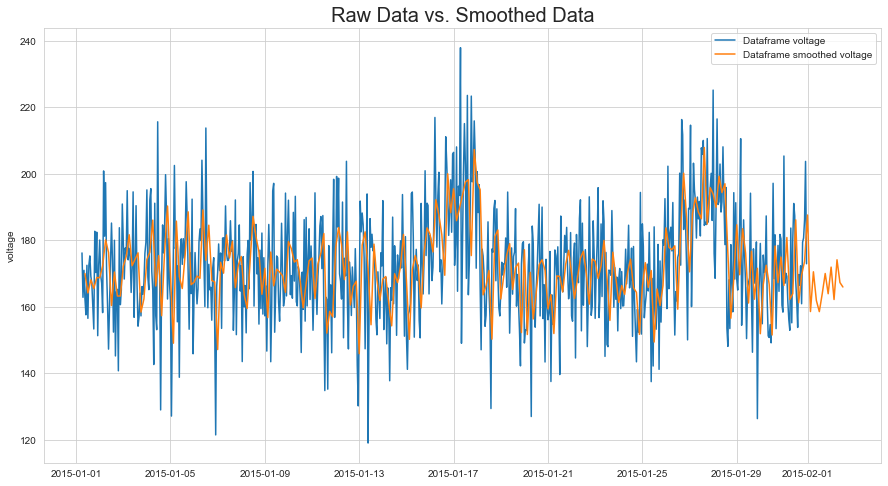

In [8]:
import matplotlib.pyplot as plt
plot_df = telemetry.loc[(telemetry['machineID'] == 1) & 
                        (telemetry['datetime'] > pd.to_datetime('2015-01-01')) & 
                        (telemetry['datetime'] < pd.to_datetime('2015-02-01')),
                        ['datetime','volt', 'rotate', 'pressure', 'vibration']]


plot_df3 = telemetry_mean_3h.loc[(telemetry['machineID'] == 1) & 
                        (telemetry['datetime'] > pd.to_datetime('2015-01-01')) & 
                        (telemetry['datetime'] < pd.to_datetime('2015-01-12')),
                        ['datetime','voltmean_3h', 'rotatemean_3h', 'pressuremean_3h', 'vibrationmean_3h']]

plt.figure(figsize=(15, 8))
sns.set_style("whitegrid")
plt.plot(plot_df['datetime'], plot_df['volt'], label='Dataframe voltage')
leg = plt.legend();
plt.ylabel('voltage')

sns.set_style("whitegrid")
plt.plot(plot_df3['datetime'], plot_df3['voltmean_3h'], label='Dataframe smoothed voltage')
leg = plt.legend();
plt.ylabel('voltage')

plt.title('Raw Data vs. Smoothed Data', fontsize=20)
plt.show()

In [9]:
# merge columns of feature sets created earlier
telemetry_feat = pd.concat([telemetry_mean_3h,
                            telemetry_sd_3h.iloc[:, 2:6],
                            telemetry_mean_24h.iloc[:, 2:6],
                            telemetry_sd_24h.iloc[:, 2:6]], axis=1).dropna()
telemetry_feat.describe()

machineID    voltmean_3h  rotatemean_3h  pressuremean_3h  \
count  290601.000000  290601.000000  290601.000000    290601.000000   
mean       50.380935     170.774427     446.609386       100.858340   
std        28.798424       9.498824      33.119738         7.411701   
min         1.000000     125.532506     211.811184        72.118639   
25%        25.000000     164.447794     427.564793        96.239534   
50%        50.000000     170.432407     448.380260       100.235357   
75%        75.000000     176.610017     468.443933       104.406534   
max       100.000000     241.420717     586.682904       162.309656   

       vibrationmean_3h      voltsd_3h    rotatesd_3h  pressuresd_3h  \
count     290601.000000  290601.000000  290601.000000  290601.000000   
mean          40.383609      13.300173      44.453951       8.885780   
std            3.475512       6.966389      23.214291       4.656364   
min           26.569635       0.025509       0.078991       0.027417   
25%           38.147458       8.028675      26.906319       5.369959   
50%           40.145874      12.495542      41.793798       8.345801   
75%           42.226898      17.688520      59.092354      11.789358   
max           69.311324      58.444332     179.903039      35.659369   

       vibrationsd_3h   voltmean_24h  rotatemean_24h  pressuremean_24h  \
count   290601.000000  290601.000000   290601.000000     290601.000000   
mean         4.440575     170.775661      446.609874        100.857574   
std          2.319989       4.720237       18.070458          4.737293   
min          0.015278     155.812721      266.010419         91.057429   
25%          2.684556     168.072275      441.542561         98.669734   
50%          4.173704     170.212704      449.206885        100.099533   
75%          5.898512     172.462228      456.366349        101.613047   
max         18.305595     220.782618      499.096975        152.310351   

       vibrationmean_24h     voltsd_24h   rotatesd_24h  pressuresd_24h  \
count      290601.000000  290601.000000  290601.000000   290601.000000   
mean           40.383881      14.919452      49.950788       10.046380   
std             2.058059       2.261097       7.684305        1.713206   
min            35.060087       6.380619      18.385248        4.145308   
25%            39.354077      13.359069      44.669022        8.924165   
50%            40.072618      14.854186      49.617459        9.921332   
75%            40.833112      16.395372      54.826993       10.980250   
max            61.932124      27.664538     103.819404       28.654103   

       vibrationsd_24h  
count    290601.000000  
mean          5.002089  
std           0.799599  
min           2.144863  
25%           4.460675  
50%           4.958793  
75%           5.484430  
max          12.325783

In [10]:
telemetry_feat.head()

machineID            datetime  voltmean_3h  rotatemean_3h  \
7           1 2015-01-02 06:00:00   180.133784     440.608320   
8           1 2015-01-02 09:00:00   176.364293     439.349655   
9           1 2015-01-02 12:00:00   160.384568     424.385316   
10          1 2015-01-02 15:00:00   170.472461     442.933997   
11          1 2015-01-02 18:00:00   163.263806     468.937558   

    pressuremean_3h  vibrationmean_3h  voltsd_3h  rotatesd_3h  pressuresd_3h  \
7         94.137969         41.551544  21.322735    48.770512       2.135684   
8        101.553209         36.105580  18.952210    51.329636      13.789279   
9         99.598722         36.094637  13.047080    13.702496       9.988609   
10       102.380586         40.483002  16.642354    56.290447       3.305739   
11       102.726648         40.921802  17.424688    38.680380       9.105775   

    vibrationsd_3h  voltmean_24h  rotatemean_24h  pressuremean_24h  \
7        10.037208    169.733809      445.179865         96.797113   
8         6.737739    170.614862      446.364859         96.849785   
9         1.639962    169.893965      447.009407         97.715600   
10        8.854145    171.243444      444.233563         96.666060   
11        3.060781    170.792486      448.440437         95.766838   

    vibrationmean_24h  voltsd_24h  rotatesd_24h  pressuresd_24h  \
7           40.385160   15.726970     39.648116       11.904700   
8           39.736826   15.635083     41.828592       11.326412   
9           39.498374   13.995465     40.843882       11.036546   
10          40.229370   13.100364     43.409841       10.972862   
11          40.055214   13.808489     43.742304       10.988704   

    vibrationsd_24h  
7          5.601191  
8          5.583521  
9          5.561553  
10         6.068674  
11         7.286129

### Dummy-Variablen

  Transformiert man eine Gruppe von nominalen Variablen in Binär-Variablen, so nennt man diese Dummy-Variablen. Definiere für $j=1,...,m$
  <center>
      $xd_{j} = \begin{cases}
         1 & \text{falls} \quad x=j \\
        0& \text{sonst.}
        \end{cases}$
  </center>
Die m binären Variablen $xd_{1}, xd_{2},..., xd_{m}$ sind linear abhängig, deswegen lässt man eine (beliebige) davon weg (Referenzkategorie) und fügt die übrigen dem Modell hinzu (Kiesel, Lineare Regression-2019, S. 10).


In [11]:
# create a column for each error type
error_count = pd.get_dummies(errors.set_index('datetime')).reset_index()
error_count
error_count.columns = ['datetime', 'machineID', 'error1', 'error2', 'error3', 'error4', 'error5']
error_count.head(100)

datetime  machineID  error1  error2  error3  error4  error5
0  2015-01-03 07:00:00          1       1       0       0       0       0
1  2015-01-03 20:00:00          1       0       0       1       0       0
2  2015-01-04 06:00:00          1       0       0       0       0       1
3  2015-01-10 15:00:00          1       0       0       0       1       0
4  2015-01-22 10:00:00          1       0       0       0       1       0
..                 ...        ...     ...     ...     ...     ...     ...
95 2015-10-31 23:00:00          3       0       1       0       0       0
96 2015-11-07 15:00:00          3       0       0       0       1       0
97 2015-11-20 23:00:00          3       1       0       0       0       0
98 2015-12-02 06:00:00          3       0       1       0       0       0
99 2015-12-02 06:00:00          3       0       0       1       0       0

[100 rows x 7 columns]

In [12]:
# combine errors for a given machine in a given hour
error_count = error_count.groupby(['machineID','datetime']).sum().reset_index()
error_count.head(100)

machineID            datetime  error1  error2  error3  error4  error5
0           1 2015-01-03 07:00:00       1       0       0       0       0
1           1 2015-01-03 20:00:00       0       0       1       0       0
2           1 2015-01-04 06:00:00       0       0       0       0       1
3           1 2015-01-10 15:00:00       0       0       0       1       0
4           1 2015-01-22 10:00:00       0       0       0       1       0
..        ...                 ...     ...     ...     ...     ...     ...
95          4 2015-01-13 18:00:00       0       1       0       0       0
96          4 2015-01-14 21:00:00       1       0       0       0       0
97          4 2015-01-16 06:00:00       0       1       1       0       0
98          4 2015-02-12 15:00:00       0       1       0       0       0
99          4 2015-02-15 06:00:00       1       0       0       0       0

[100 rows x 7 columns]

In [13]:
error_count = telemetry[['datetime', 'machineID']].merge(error_count, on=['machineID', 'datetime'], how='left').fillna(0.0)
error_count.describe()

machineID         error1         error2         error3  \
count  876100.000000  876100.000000  876100.000000  876100.000000   
mean       50.500000       0.001153       0.001128       0.000957   
std        28.866087       0.033934       0.033563       0.030913   
min         1.000000       0.000000       0.000000       0.000000   
25%        25.750000       0.000000       0.000000       0.000000   
50%        50.500000       0.000000       0.000000       0.000000   
75%        75.250000       0.000000       0.000000       0.000000   
max       100.000000       1.000000       1.000000       1.000000   

              error4         error5  
count  876100.000000  876100.000000  
mean        0.000830       0.000406  
std         0.028795       0.020154  
min         0.000000       0.000000  
25%         0.000000       0.000000  
50%         0.000000       0.000000  
75%         0.000000       0.000000  
max         1.000000       1.000000

In [14]:
temp = []
fields = ['error%d' % i for i in range(1,6)]
for col in fields:
    temp.append((pd.pivot_table(error_count, index='datetime', columns='machineID', values=col).
                 rolling(window=24, center=False).sum().
                 resample('3H', closed='left', label='right').first().unstack()))
    
error_count = pd.concat(temp, axis=1)
error_count.columns = [i + 'count' for i in fields]
error_count.reset_index(inplace=True)
error_count = error_count.dropna()
error_count.describe()

machineID    error1count    error2count    error3count  \
count  291400.00000  291400.000000  291400.000000  291400.000000   
mean       50.50000       0.027649       0.027069       0.022907   
std        28.86612       0.166273       0.164429       0.151453   
min         1.00000       0.000000       0.000000       0.000000   
25%        25.75000       0.000000       0.000000       0.000000   
50%        50.50000       0.000000       0.000000       0.000000   
75%        75.25000       0.000000       0.000000       0.000000   
max       100.00000       2.000000       2.000000       2.000000   

         error4count    error5count  
count  291400.000000  291400.000000  
mean        0.019904       0.009753  
std         0.140820       0.098797  
min         0.000000       0.000000  
25%         0.000000       0.000000  
50%         0.000000       0.000000  
75%         0.000000       0.000000  
max         2.000000       2.000000

In [15]:
error_count.head(1000)

machineID            datetime  error1count  error2count  error3count  \
7             1 2015-01-02 06:00:00          0.0          0.0          0.0   
8             1 2015-01-02 09:00:00          0.0          0.0          0.0   
9             1 2015-01-02 12:00:00          0.0          0.0          0.0   
10            1 2015-01-02 15:00:00          0.0          0.0          0.0   
11            1 2015-01-02 18:00:00          0.0          0.0          0.0   
...         ...                 ...          ...          ...          ...   
1002          1 2015-05-06 15:00:00          0.0          0.0          0.0   
1003          1 2015-05-06 18:00:00          0.0          0.0          0.0   
1004          1 2015-05-06 21:00:00          0.0          0.0          0.0   
1005          1 2015-05-07 00:00:00          0.0          0.0          0.0   
1006          1 2015-05-07 03:00:00          0.0          0.0          0.0   

      error4count  error5count  
7             0.0          0.0  
8             0.0          0.0  
9             0.0          0.0  
10            0.0          0.0  
11            0.0          0.0  
...           ...          ...  
1002          0.0          0.0  
1003          0.0          0.0  
1004          0.0          0.0  
1005          0.0          0.0  
1006          0.0          0.0  

[1000 rows x 7 columns]

In [16]:
# create a column for each error type
comp_rep = pd.get_dummies(maint.set_index('datetime')).reset_index()
comp_rep.columns = ['datetime', 'machineID', 'comp1', 'comp2', 'comp3', 'comp4']
# combine repairs for a given machine in a given hour
comp_rep = comp_rep.groupby(['machineID', 'datetime']).sum().reset_index()
# add timepoints where no components were replaced

comp_rep = telemetry[['datetime', 'machineID']].merge(comp_rep,
                                                      on=['datetime', 'machineID'],
                                                      how='outer').fillna(0).sort_values(by=['machineID', 'datetime'])
components = ['comp1', 'comp2', 'comp3', 'comp4']
df_temp = pd.DataFrame()
for comp in components:
    # convert indicator to most recent date of component change
    comp_rep.loc[comp_rep[comp] < 1, comp] = None
    df_temp[comp] = comp_rep.loc[-comp_rep[comp].isnull(), 'datetime']


Es gibt zwei Hauptgründe, warum man sich für eine erneute Stichprobenziehung ihrer Zeitreihendaten interessieren könnte:
<ul>
  <li> <b>Problem Framing:</b> Hier wird Resampling erforderlich, falls die Daten nicht mit der gewünschten Häufigkeit, mit der man die Vorhersage machen will, vorliegen.</li>
  <li> <b>Feature Engineering:</b> Resampling kann auch verwendet werden, um zusätzlich Struktur oder Einblicke in das Lernproblem für Supervised Learning Modelle bereitzustellen.</li>
</ul>
Es gibt viele Überschneidungen zwischen diesen beiden Fällen (Brownlee, 2020, S. 53 - 54).

In [17]:
# create a column for each error type
comp_rep = pd.get_dummies(maint.set_index('datetime')).reset_index()
comp_rep.columns = ['datetime', 'machineID', 'comp1', 'comp2', 'comp3', 'comp4']
# combine repairs for a given machine in a given hour
comp_rep = comp_rep.groupby(['machineID', 'datetime']).sum().reset_index()

In [18]:
comp_rep = pd.get_dummies(maint.set_index('datetime')).reset_index()
comp_rep.columns = ['datetime', 'machineID', 'comp1', 'comp2', 'comp3', 'comp4']
comp_rep = comp_rep.groupby(['machineID', 'datetime']).sum().reset_index()
comp_rep = telemetry[['datetime', 'machineID']].merge(comp_rep,
                                                      on=['datetime', 'machineID'],
                                                      how='outer').fillna(0).sort_values(by=['machineID', 'datetime'])
components = ['comp1', 'comp2', 'comp3', 'comp4']
for comp in components:
    # convert indicator to most recent date of component change
    comp_rep.loc[comp_rep[comp] < 1, comp] = None
    comp_rep[comp] = pd.to_datetime(comp_rep[comp])
    comp_rep.loc[-comp_rep[comp].isnull(), comp] = comp_rep.datetime
    
    # forward-fill the most-recent date of component change
    comp_rep[comp] = comp_rep[comp].fillna(method='ffill')

comp_rep = comp_rep.loc[comp_rep['datetime'] > pd.to_datetime('2015-01-01')]

# Cast from timedelta64 to float 64
for comp in components:
    comp_rep[comp] = (comp_rep['datetime'] - comp_rep[comp]) / np.timedelta64(1, 'D')
    
comp_rep.describe()

machineID          comp1          comp2          comp3  \
count  876100.000000  876100.000000  876100.000000  876100.000000   
mean       50.500000      53.525185      51.540806      52.725962   
std        28.866087      62.491679      59.269254      58.873114   
min         1.000000       0.000000       0.000000       0.000000   
25%        25.750000      13.291667      12.125000      13.125000   
50%        50.500000      32.791667      29.666667      32.291667   
75%        75.250000      68.708333      66.541667      67.333333   
max       100.000000     491.958333     348.958333     370.958333   

               comp4  
count  876100.000000  
mean       53.834191  
std        59.707978  
min         0.000000  
25%        13.000000  
50%        32.500000  
75%        70.458333  
max       394.958333

In [19]:
comp_rep.head(1540)

datetime  machineID      comp1       comp2       comp3  \
0    2015-01-01 06:00:00          1  19.000000  214.000000  154.000000   
1    2015-01-01 07:00:00          1  19.041667  214.041667  154.041667   
2    2015-01-01 08:00:00          1  19.083333  214.083333  154.083333   
3    2015-01-01 09:00:00          1  19.125000  214.125000  154.125000   
4    2015-01-01 10:00:00          1  19.166667  214.166667  154.166667   
...                  ...        ...        ...         ...         ...   
1535 2015-03-06 05:00:00          1  44.958333  277.958333   14.958333   
1536 2015-03-06 06:00:00          1   0.000000  278.000000   15.000000   
1537 2015-03-06 07:00:00          1   0.041667  278.041667   15.041667   
1538 2015-03-06 08:00:00          1   0.083333  278.083333   15.083333   
1539 2015-03-06 09:00:00          1   0.125000  278.125000   15.125000   

           comp4  
0     169.000000  
1     169.041667  
2     169.083333  
3     169.125000  
4     169.166667  
...          ...  
1535   29.958333  
1536   30.000000  
1537   30.041667  
1538   30.083333  
1539   30.125000  

[1540 rows x 6 columns]

# Merging Final Table

In [20]:
final_feat = telemetry_feat.merge(error_count, on=['datetime', 'machineID'], how='left')
final_feat = final_feat.merge(comp_rep, on=['datetime', 'machineID'], how='left')
final_feat = final_feat.merge(machines, on=['machineID'], how='left')

final_feat.describe()

machineID    voltmean_3h  rotatemean_3h  pressuremean_3h  \
count  290601.000000  290601.000000  290601.000000    290601.000000   
mean       50.380935     170.774427     446.609386       100.858340   
std        28.798424       9.498824      33.119738         7.411701   
min         1.000000     125.532506     211.811184        72.118639   
25%        25.000000     164.447794     427.564793        96.239534   
50%        50.000000     170.432407     448.380260       100.235357   
75%        75.000000     176.610017     468.443933       104.406534   
max       100.000000     241.420717     586.682904       162.309656   

       vibrationmean_3h      voltsd_3h    rotatesd_3h  pressuresd_3h  \
count     290601.000000  290601.000000  290601.000000  290601.000000   
mean          40.383609      13.300173      44.453951       8.885780   
std            3.475512       6.966389      23.214291       4.656364   
min           26.569635       0.025509       0.078991       0.027417   
25%           38.147458       8.028675      26.906319       5.369959   
50%           40.145874      12.495542      41.793798       8.345801   
75%           42.226898      17.688520      59.092354      11.789358   
max           69.311324      58.444332     179.903039      35.659369   

       vibrationsd_3h   voltmean_24h  ...    error1count    error2count  \
count   290601.000000  290601.000000  ...  290601.000000  290601.000000   
mean         4.440575     170.775661  ...       0.027560       0.027058   
std          2.319989       4.720237  ...       0.166026       0.164401   
min          0.015278     155.812721  ...       0.000000       0.000000   
25%          2.684556     168.072275  ...       0.000000       0.000000   
50%          4.173704     170.212704  ...       0.000000       0.000000   
75%          5.898512     172.462228  ...       0.000000       0.000000   
max         18.305595     220.782618  ...       2.000000       2.000000   

         error3count    error4count    error5count          comp1  \
count  290601.000000  290601.000000  290601.000000  290601.000000   
mean        0.022846       0.019955       0.009780      53.382610   
std         0.151266       0.140998       0.098931      62.478424   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000      13.250000   
50%         0.000000       0.000000       0.000000      32.625000   
75%         0.000000       0.000000       0.000000      68.500000   
max         2.000000       2.000000       2.000000     491.875000   

               comp2          comp3          comp4            age  
count  290601.000000  290601.000000  290601.000000  290601.000000  
mean       51.256589      52.536687      53.679601      11.345226  
std        59.156008      58.822946      59.658975       5.826345  
min         0.000000       0.000000       0.000000       0.000000  
25%        12.000000      13.000000      12.875000       7.000000  
50%        29.500000      32.125000      32.375000      12.000000  
75%        65.875000      67.125000      70.250000      16.000000  
max       348.875000     370.875000     394.875000      20.000000  

[8 rows x 27 columns]

In [21]:
labeled_features = final_feat.merge(failures, on=['datetime', 'machineID'], how='left')
labeled_features = labeled_features.bfill(axis=1, limit=7) # fill backward up to 24h
labeled_features = labeled_features.fillna('none')
labeled_features.head()

machineID            datetime  voltmean_3h  rotatemean_3h  pressuremean_3h  \
0          1 2015-01-02 06:00:00   180.133784     440.608320        94.137969   
1          1 2015-01-02 09:00:00   176.364293     439.349655       101.553209   
2          1 2015-01-02 12:00:00   160.384568     424.385316        99.598722   
3          1 2015-01-02 15:00:00   170.472461     442.933997       102.380586   
4          1 2015-01-02 18:00:00   163.263806     468.937558       102.726648   

   vibrationmean_3h  voltsd_3h  rotatesd_3h  pressuresd_3h  vibrationsd_3h  \
0         41.551544  21.322735    48.770512       2.135684       10.037208   
1         36.105580  18.952210    51.329636      13.789279        6.737739   
2         36.094637  13.047080    13.702496       9.988609        1.639962   
3         40.483002  16.642354    56.290447       3.305739        8.854145   
4         40.921802  17.424688    38.680380       9.105775        3.060781   

   ...  error3count  error4count  error5count   comp1    comp2    comp3  \
0  ...          0.0          0.0          0.0  20.000  215.000  155.000   
1  ...          0.0          0.0          0.0  20.125  215.125  155.125   
2  ...          0.0          0.0          0.0  20.250  215.250  155.250   
3  ...          0.0          0.0          0.0  20.375  215.375  155.375   
4  ...          0.0          0.0          0.0  20.500  215.500  155.500   

     comp4   model  age  failure  
0  170.000  model3   18     none  
1  170.125  model3   18     none  
2  170.250  model3   18     none  
3  170.375  model3   18     none  
4  170.500  model3   18     none  

[5 rows x 30 columns]

In [22]:
labeled_features.loc[labeled_features['failure'] == 'comp4'][:16]

machineID            datetime  voltmean_3h  rotatemean_3h  \
24             1 2015-01-05 06:00:00   185.782709     439.531288   
1344           1 2015-06-19 06:00:00   172.059069     463.242610   
1944           1 2015-09-02 06:00:00   165.530175     413.547130   
2784           1 2015-12-16 06:00:00   188.941806     421.756494   
17656          7 2015-01-24 06:00:00   177.669082     361.502737   
18496          7 2015-05-09 06:00:00   175.911702     467.458682   
19576          7 2015-09-21 06:00:00   169.123329     428.763286   
21025          8 2015-03-22 06:00:00   173.026438     429.852151   
22105          8 2015-08-04 06:00:00   178.611054     425.076676   
22705          8 2015-10-18 06:00:00   166.642406     452.842842   
35753         13 2015-04-11 06:00:00   168.588404     412.999145   
36353         13 2015-06-25 06:00:00   179.947227     431.130008   
37074         13 2015-09-23 06:00:00   164.577531     502.795961   
37674         13 2015-12-07 06:00:00   161.429150     436.392261   
40934         15 2015-01-20 06:00:00   153.421038     332.878924   
43215         15 2015-11-01 06:00:00   158.243837     356.931968   

       pressuremean_3h  vibrationmean_3h  voltsd_3h  rotatesd_3h  \
24           99.413660         51.558082  14.495664    45.663743   
1344         96.905050         53.701413  14.757880    55.874000   
1944        103.631528         60.142846   9.088618    49.918671   
2784         86.684047         51.410144  35.295874     7.839110   
17656       109.447331         46.975392   8.531048    29.773424   
18496       103.589910         52.610306  12.400140    69.604586   
19576        99.428189         45.397202  21.723826   100.568119   
21025       102.408383         54.340943  11.452078    42.822464   
22105       102.481539         48.617995  12.652412    22.014775   
22705       104.470047         52.080654   5.920407    46.523492   
35753       129.963982         45.168217  30.404119    19.773744   
36353       100.685572         50.529497  22.494798    13.375566   
37074        94.420511         53.939259  11.307022    45.064863   
37674       106.976974         51.885821  15.670547    20.735401   
40934        91.224875         47.956794  32.361173    33.782360   
43215        97.001626         53.872016   1.698815   129.846493   

       pressuresd_3h  vibrationsd_3h  ...  error3count  error4count  \
24          4.289212        7.330397  ...          0.0          0.0   
1344        3.204981        2.329615  ...          0.0          0.0   
1944       14.438808        5.389723  ...          0.0          0.0   
2784        9.139511        3.598700  ...          0.0          0.0   
17656       4.384169        5.187506  ...          1.0          0.0   
18496      11.162580        1.658487  ...          0.0          0.0   
19576      22.697296        3.416446  ...          0.0          0.0   
21025      11.195405        7.115879  ...          0.0          0.0   
22105      18.517554        2.918507  ...          0.0          0.0   
22705       5.792959        4.005665  ...          0.0          0.0   
35753      11.912972        7.454374  ...          0.0          1.0   
36353       8.247416        2.868267  ...          0.0          0.0   
37074       7.435227        5.308316  ...          0.0          0.0   
37674       7.240461        3.050824  ...          0.0          0.0   
40934       2.465201        7.515406  ...          1.0          0.0   
43215       5.481153        8.493348  ...          1.0          0.0   

       error5count  comp1  comp2  comp3  comp4   model  age  failure  
24             1.0    0.0  218.0  158.0    0.0  model3   18    comp4  
1344           1.0    0.0   30.0   15.0    0.0  model3   18    comp4  
1944           1.0    0.0   60.0   90.0    0.0  model3   18    comp4  
2784           1.0   75.0   30.0   15.0    0.0  model3   18    comp4  
17656          1.0  207.0    0.0  207.0    0.0  model3   20    comp4  
18496          1.0    0.0   30.0   45.0    0.0  model3   20

In [23]:
labeled_features.to_csv(r'C:\Users\Admin\Google Drive\Projekte\Data\final.csv', index=False)

In [24]:
from sklearn.ensemble import GradientBoostingClassifier

# make test and training splits
threshold_dates = [[pd.to_datetime('2015-07-31 01:00:00'), pd.to_datetime('2015-08-01 01:00:00')],
                   [pd.to_datetime('2015-08-31 01:00:00'), pd.to_datetime('2015-09-01 01:00:00')],
                   [pd.to_datetime('2015-09-30 01:00:00'), pd.to_datetime('2015-10-01 01:00:00')]]

test_results = []
models = []
for last_train_date, first_test_date in threshold_dates:
    # split out training and test data
    train_y = labeled_features.loc[labeled_features['datetime'] < last_train_date, 'failure']
    train_X = pd.get_dummies(labeled_features.loc[labeled_features['datetime'] < last_train_date].drop(['datetime',
                                                                                                        'machineID',
                                                                                                        'failure'], 1))
    test_X = pd.get_dummies(labeled_features.loc[labeled_features['datetime'] > first_test_date].drop(['datetime',
                                                                                                       'machineID',
                                                                                                       'failure'], 1))
    # train and predict using the model, storing results for later
    my_model = GradientBoostingClassifier(random_state=42)
    my_model.fit(train_X, train_y)
    test_result = pd.DataFrame(labeled_features.loc[labeled_features['datetime'] > first_test_date])
    test_result['predicted_failure'] = my_model.predict(test_X)
    test_results.append(test_result)
    models.append(my_model)

Text(0, 0.5, 'Importance')

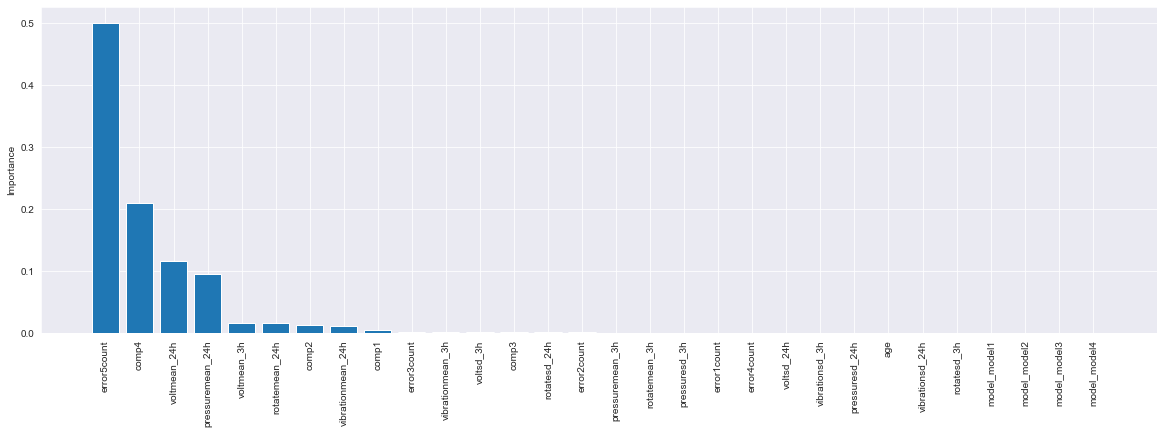

In [38]:
sns.set_style("darkgrid")
plt.figure(figsize=(20, 6))
labels, importances = zip(*sorted(zip(test_X.columns, models[0].feature_importances_), reverse=True, key=lambda x: x[1]))
plt.xticks(range(len(labels)), labels)
_, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.bar(range(len(importances)), importances)
plt.ylabel('Importance')

Text(0, 0.5, 'Count')

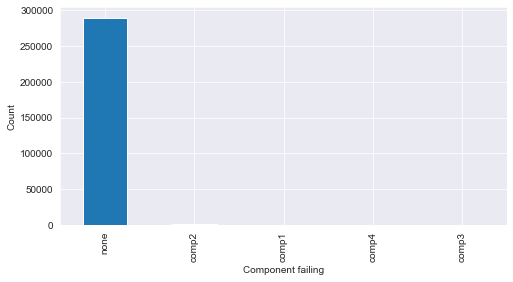

In [26]:
sns.set_style("darkgrid")
plt.figure(figsize=(8, 4))
labeled_features['failure'].value_counts().plot(kind='bar')
plt.xlabel('Component failing')
plt.ylabel('Count')

In [27]:
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, precision_score

def Evaluate(predicted, actual, labels):
    output_labels = []
    output = []
    
    # Calculate and display confusion matrix
    cm = confusion_matrix(actual, predicted, labels=labels)
    print('Confusion matrix\n- x-axis is true labels (none, comp1, etc.)\n- y-axis is predicted labels')
    print(cm)
    
    # Calculate precision, recall, and F1 score
    accuracy = np.array([float(np.trace(cm)) / np.sum(cm)] * len(labels))
    precision = precision_score(actual, predicted, average=None, labels=labels)
    recall = recall_score(actual, predicted, average=None, labels=labels)
    f1 = 2 * precision * recall / (precision + recall)
    output.extend([accuracy.tolist(), precision.tolist(), recall.tolist(), f1.tolist()])
    output_labels.extend(['accuracy', 'precision', 'recall', 'F1'])
    
    # Calculate the macro versions of these metrics
    output.extend([[np.mean(precision)] * len(labels),
                   [np.mean(recall)] * len(labels),
                   [np.mean(f1)] * len(labels)])
    output_labels.extend(['macro precision', 'macro recall', 'macro F1'])
    
    # Find the one-vs.-all confusion matrix
    cm_row_sums = cm.sum(axis = 1)
    cm_col_sums = cm.sum(axis = 0)
    s = np.zeros((2, 2))
    for i in range(len(labels)):
        v = np.array([[cm[i, i],
                       cm_row_sums[i] - cm[i, i]],
                      [cm_col_sums[i] - cm[i, i],
                       np.sum(cm) + cm[i, i] - (cm_row_sums[i] + cm_col_sums[i])]])
        s += v
    s_row_sums = s.sum(axis = 1)
    
    # Add average accuracy and micro-averaged  precision/recall/F1
    avg_accuracy = [np.trace(s) / np.sum(s)] * len(labels)
    micro_prf = [float(s[0,0]) / s_row_sums[0]] * len(labels)
    output.extend([avg_accuracy, micro_prf])
    output_labels.extend(['average accuracy',
                          'micro-averaged precision/recall/F1'])
    
    # Compute metrics for the majority classifier
    mc_index = np.where(cm_row_sums == np.max(cm_row_sums))[0][0]
    cm_row_dist = cm_row_sums / float(np.sum(cm))
    mc_accuracy = 0 * cm_row_dist; mc_accuracy[mc_index] = cm_row_dist[mc_index]
    mc_recall = 0 * cm_row_dist; mc_recall[mc_index] = 1
    mc_precision = 0 * cm_row_dist
    mc_precision[mc_index] = cm_row_dist[mc_index]
    mc_F1 = 0 * cm_row_dist;
    mc_F1[mc_index] = 2 * mc_precision[mc_index] / (mc_precision[mc_index] + 1)
    output.extend([mc_accuracy.tolist(), mc_recall.tolist(),
                   mc_precision.tolist(), mc_F1.tolist()])
    output_labels.extend(['majority class accuracy', 'majority class recall',
                          'majority class precision', 'majority class F1'])
        
    # Random accuracy and kappa
    cm_col_dist = cm_col_sums / float(np.sum(cm))
    exp_accuracy = np.array([np.sum(cm_row_dist * cm_col_dist)] * len(labels))
    kappa = (accuracy - exp_accuracy) / (1 - exp_accuracy)
    output.extend([exp_accuracy.tolist(), kappa.tolist()])
    output_labels.extend(['expected accuracy', 'kappa'])
    

    # Random guess
    rg_accuracy = np.ones(len(labels)) / float(len(labels))
    rg_precision = cm_row_dist
    rg_recall = np.ones(len(labels)) / float(len(labels))
    rg_F1 = 2 * cm_row_dist / (len(labels) * cm_row_dist + 1)
    output.extend([rg_accuracy.tolist(), rg_precision.tolist(),
                   rg_recall.tolist(), rg_F1.tolist()])
    output_labels.extend(['random guess accuracy', 'random guess precision',
                          'random guess recall', 'random guess F1'])
    
    # Random weighted guess
    rwg_accuracy = np.ones(len(labels)) * sum(cm_row_dist**2)
    rwg_precision = cm_row_dist
    rwg_recall = cm_row_dist
    rwg_F1 = cm_row_dist
    output.extend([rwg_accuracy.tolist(), rwg_precision.tolist(),
                   rwg_recall.tolist(), rwg_F1.tolist()])
    output_labels.extend(['random weighted guess accuracy',
                          'random weighted guess precision',
                          'random weighted guess recall',
                          'random weighted guess F1'])

    output_df = pd.DataFrame(output, columns=labels)
    output_df.index = output_labels
                  
    return output_df
evaluation_results = []
for i, test_result in enumerate(test_results):
    print('\nSplit %d:' % (i+1))
    evaluation_result = Evaluate(actual = test_result['failure'],
                                 predicted = test_result['predicted_failure'],
                                 labels = ['none', 'comp1', 'comp2', 'comp3', 'comp4'])
    evaluation_results.append(evaluation_result)
evaluation_results[0]  # show full results for first split only


Split 1:
Confusion matrix
- x-axis is true labels (none, comp1, etc.)
- y-axis is predicted labels
[[121582     15     10     11      0]
 [     6     49      3      6      2]
 [     0     19     91      1      0]
 [     0      1      2     49      0]
 [     1     70      0      0      2]]

Split 2:
Confusion matrix
- x-axis is true labels (none, comp1, etc.)
- y-axis is predicted labels
[[96854     7     7     7     1]
 [    3    46     1     1     0]
 [   15     1    74     0     0]
 [    8     0     2    29     1]
 [   56     0     0     0     1]]

Split 3:
Confusion matrix
- x-axis is true labels (none, comp1, etc.)
- y-axis is predicted labels
[[72918    11     1     0     1]
 [    1    34     2     0     2]
 [   50     6     9     5     1]
 [    3    13     0    11     1]
 [    9     4     0     0    28]]


none     comp1     comp2     comp3  \
accuracy                            0.998794  0.998794  0.998794  0.998794   
precision                           0.999942  0.318182  0.858491  0.731343   
recall                              0.999704  0.742424  0.819820  0.942308   
F1                                  0.999823  0.445455  0.838710  0.823529   
macro precision                     0.681592  0.681592  0.681592  0.681592   
macro recall                        0.706331  0.706331  0.706331  0.706331   
macro F1                            0.631893  0.631893  0.631893  0.631893   
average accuracy                    0.999518  0.999518  0.999518  0.999518   
micro-averaged precision/recall/F1  0.998794  0.998794  0.998794  0.998794   
majority class accuracy             0.997523  0.000000  0.000000  0.000000   
majority class recall               1.000000  0.000000  0.000000  0.000000   
majority class precision            0.997523  0.000000  0.000000  0.000000   
majority class F1                   0.998760  0.000000  0.000000  0.000000   
expected accuracy                   0.994817  0.994817  0.994817  0.994817   
kappa                               0.767394  0.767394  0.767394  0.767394   
random guess accuracy               0.200000  0.200000  0.200000  0.200000   
random guess precision              0.997523  0.000541  0.000910  0.000427   
random guess recall                 0.200000  0.200000  0.200000  0.200000   
random guess F1                     0.333195  0.001080  0.001813  0.000851   
random weighted guess accuracy      0.995054  0.995054  0.995054  0.995054   
random weighted guess precision     0.997523  0.000541  0.000910  0.000427   
random weighted guess recall        0.997523  0.000541  0.000910  0.000427   
random weighted guess F1            0.997523  0.000541  0.000910  0.000427   

                                       comp4  
accuracy                            0.998794  
precision                           0.500000  
recall                              0.027397  
F1                                  0.051948  
macro precision                     0.681592  
macro recall                        0.706331  
macro F1                            0.631893  
average accuracy                    0.999518  
micro-averaged precision/recall/F1  0.998794  
majority class accuracy             0.000000  
majority class recall               0.000000  
majority class precision            0.000000  
majority class F1                   0.000000  
expected accuracy                   0.994817  
kappa                               0.767394  
random guess accuracy               0.200000  
random guess precision              0.000599  
random guess recall                 0.200000  
random guess F1                     0.001194  
random weighted guess accuracy      0.995054  
random weighted guess precision     0.000599  
random weighted guess recall        0.000599  
random weighted guess F1            0.000599